

### **CS4287: Neural Networks**


####Assignment 1: Multi Layer Perceptron

##### Ranya El-Hwigi (18227449) Nutsa Chichilidze (18131956) 



---

Code runs to completion

The best result we achieved was a categorical accuracy of : 

In [ ]:
# importing and installing the necessary packages
!pip install contractions

import os
import re
import pydot
import shutil
import string
import numpy as np
import contractions
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras import losses
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report  
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

     |████████████████████████████████| 284 kB 33.9 MB/s 
     |████████████████████████████████| 321 kB 65.2 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85437 sha256=5190b765c2606a0eebc052bdbec5246131847c668a178bd6d63e38d772488a8c
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


**Importing Data**

We use the [Tweet sentiment extraction dataset](https://www.kaggle.com/c/tweet-sentiment-extraction/overview)

It consists of 31,015 tweets which are divided between 27,481 tweets for training and 3,534 tweets for testing. The data is made up of textual information.

Our aim is to create a classification model that can determine which tweets have a positive sentiment, which are neutral and which have a negative sentiment.

In [ ]:
# load train and test datasets
train_data= pd.read_csv("/content/train.csv")
test_data= pd.read_csv("/content/test.csv")

**Text modification**

In [ ]:
def clean_up_text(text): 
  text = text.lower()
  # expand the contractions -> we'll -> we will, won't -> will not
  text = contractions.fix(text)
  # remove url 
  text = re.sub(r"https?://\S+|www\.\S+", "", text)
  # remove html tags 
  html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
  text = re.sub(html, "", text)
  # remove non-ascii 
  text = re.sub(r'[^\x00-\x7f]',r'', text)
  # remove emoji
  text = remove_emoji(text)
  # remove punctuation 
  text = text.translate(str.maketrans('', '', string.punctuation))
  # fix spelling
  # text = TextBlob(text).correct()
  return text

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
    
# replace null values
train_data.dropna(axis = 0, how ='any',inplace=True) 
test_data.dropna(axis = 0, how ='any',inplace=True)

# count how many words in each text column row
train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split())) 
test_data['Num_words_text'] = test_data['text'].apply(lambda x:len(str(x).split())) 

# mask for sentences that have more than 2 words
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

# clean up the text in the datasets, removing unwanted characters, fixing spelling, etc. 
train_data['text'] = train_data['text'].apply(clean_up_text)
test_data['text'] = test_data['text'].apply(clean_up_text)

**Visualizing key attributes of the dataset**






Train Data


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


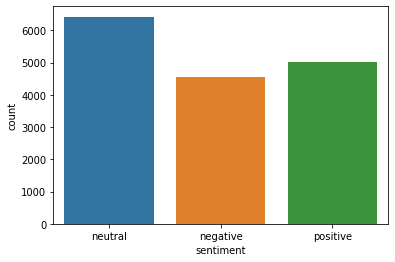

In [ ]:
# creating a count plot to visualize how many we have of each sentiment label in the train data
print("Train Data")
sns.countplot(train_data["sentiment"])

Test Data


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


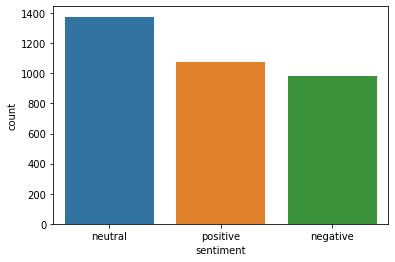

In [ ]:
# creating a count plot to visualize how many we have of each sentiment label in the test data
print("Test Data")
sns.countplot(test_data["sentiment"])

Train Data


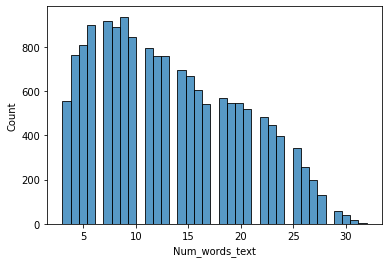

In [ ]:
# creating a histogram plot to visualize the number of words in the tweets in the train data
print("Train Data")
sns.histplot(data=train_data, x="Num_words_text")

Test Data


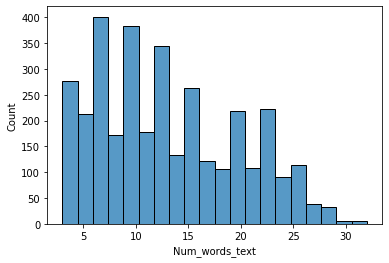

In [ ]:
# creating a histogram plot to visualize the number of words in the tweets in the test data
print("Test Data")
sns.histplot(data=test_data, x="Num_words_text")

Train data


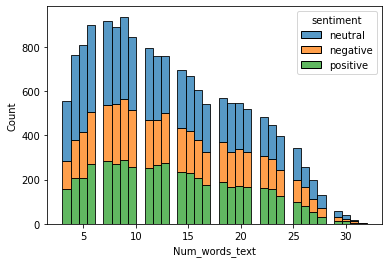

In [ ]:
# creating a histogram plot to visualize how the number of words in the tweets relate to the labels in the train data
print("Train data")
sns.histplot(data=train_data, x="Num_words_text", hue="sentiment", multiple="stack")

Test data


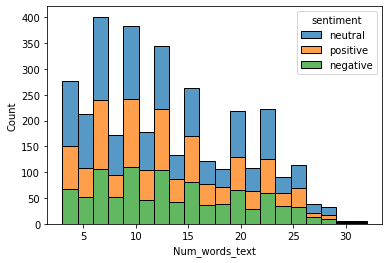

In [ ]:
# creating a histogram plot to visualize how the number of words in the tweets relate to the labels in the test data
print("Test data")
sns.histplot(data=test_data, x="Num_words_text", hue="sentiment", multiple="stack")

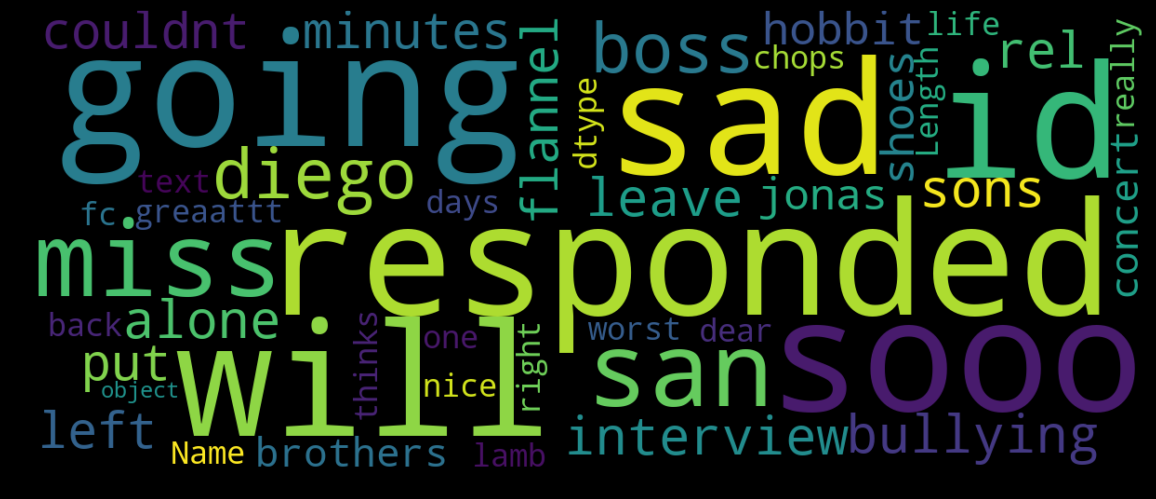

In [ ]:
# creating a word cloud to visualize the most common words in our data
wordcloud = WordCloud(
    width = 1200,
    height = 500,
    max_words=4000,
    background_color = 'black').generate(str(train_data.text))
fig = plt.figure(
    figsize = (20, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.show()

**Splitting the data: train, validation & test data**

We found examples for correctly splitting text classification data in [this implementation](https://github.com/rsreetech/TextClassificationNNTensorflow/blob/master/TensorFlowTweetTextClassification.ipynb)

In [ ]:
X = train_data['text'].tolist()
Y = train_data['sentiment'].tolist()

# splitting the dataset as normal 
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      Y, 
                                                      test_size=0.33,
                                                      stratify = Y, 
                                                      random_state=0)

x_train = np.asarray(X_train)
x_valid = np.array(X_valid)
x_test = np.asarray(test_data['text'].tolist())

# label encoder allows us to code our y or target dataset
# and convert the classes into numbers 
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))

valid_labels = le.transform(y_valid)
valid_labels = np.asarray(tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))

list(le.classes_)

train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

**Building our model**

We learned about the Keras hub layer implementation from [this tutorial](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub) 



In [ ]:
def model_builder():
  embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
  # this hub layer is one of the most important parts of our model structure
  # it is a pre-trained text embedding layer, which allows us to perform transfer learning
  # i.e. translate the inputted sentences into numbers. 
  # this way they get converted into embedding vectors 
  hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

  model = tf.keras.Sequential()


  model.add(hub_layer)
  # we use a combination of Dropout and Dense layers to maximize performace
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(3,activation='sigmoid',kernel_regularizer=regularizers.l2(0.05)))


  model.summary()

  # the optimizer Adam allows us to maximize our categorical accuracy 
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                optimizer='adam', 
                metrics=["CategoricalAccuracy"])

  return model;


**K-fold cross validation** 

some of the implementation refers to [this tutorial](https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/)

In [ ]:
def cross_validate(epoch, batch_size): 
  num_folds = 4
  print("Epoch: " + str(epoch))
  print("Batch: " + str(batch_size))

  # Merge inputs and targets
  # inputs = np.concatenate((input_train, input_test), axis=0)
  # targets = np.concatenate((target_train, target_test), axis=0)

  inputs = np.concatenate((X_train, x_test), axis=0)
  targets = np.concatenate((train_labels, test_labels), axis=0)
  acc_per_fold = []
  loss_per_fold = []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(inputs, targets):

    # getting the model
    model = model_builder()

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # fitting data to the model, note how we're using the tuned batch 
    # size and epoch hyper-parameters here to train our model
    history = model.fit(train_ds.shuffle(1000).batch(batch_size),
                    epochs=epoch ,
                    validation_data=valid_ds.batch(batch_size),
                    verbose=1)

    # generating the accuracy and loss scores
    scores = model.evaluate(x_test,test_labels, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # increasing the fold number
    fold_no = fold_no + 1

**Hyper-parameter tuning**


In [ ]:
# We decided to hyper-tune epochs and batch sizes to find the best combination of the two to increase our categorical accuracy.
# We avoided our epochs being too high to avoid overfitting. 
# Realistically, we could input as many numbers as we want in these sets, however it takes too long! 
epochs = [2, 10, 60, 100]
batch_sizes = [20, 70, 128]

for epoch in epochs:
  for batch_size in batch_sizes:
    cross_validate(epoch, batch_size)

Epoch: 2
Batch: 20
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 389,623
Trainable params: 389,623
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------------------
Training for fold 1 ...


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


Streaming output truncated to the last 5000 lines.
dropout_12 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_13 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 33        
Total params: 389,623
Trainable params: 389,623
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/2
154/154 [==============================] - 2s 8ms/step - loss: 2.1077 - categorical_accuracy: 0.3518 - val_loss: 1.6062 - val_categorical_accuracy: 0.3635
Epoch 2/2
154/154 [==============================] - 1s 6ms/step - loss: 1.5244 - categ

**Predictions**

In [ ]:
model = model_builder()
history = model.fit(train_ds.shuffle(1000).batch(128),
                    epochs=100 ,
                    validation_data=valid_ds.batch(128),
                    verbose=0)

predictions = model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)
test_data['pred_sentiment']= predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'negative',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'neutral',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '2'),'positive',test_data.pred_sentiment)

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_49 (KerasLayer)  (None, 20)                389380    
_________________________________________________________________
dropout_98 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_99 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 3)                 33        
Total params: 389,623
Trainable params: 389,623
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


[[0.4900133  0.6294482  0.3523689 ]
 [0.12448663 0.4953432  0.8655395 ]
 [0.7315801  0.62119603 0.1642187 ]
 ...
 [0.64716184 0.63020706 0.22009629]
 [0.15462458 0.51851416 0.81999755]
 [0.21422431 0.55498487 0.7248072 ]]


In [ ]:
#test_data = test_data.drop(['textID','Num_words_text'], axis=1)
test_data.head(50)

,text,sentiment,pred_sentiment
0,last session of the day,neutral,neutral
1,shanghai is also really exciting precisely s...,positive,positive
2,recession hit veronique branquinho she has to ...,negative,negative
4,i like it,positive,neutral
5,thats great weee visitors,positive,positive
6,i think everyone hates me on here lol,negative,neutral
7,soooooo wish i could but I am in school and m...,negative,neutral
8,and within a short time of the last clue all ...,neutral,neutral
9,what did you get my day is alright havent do...,neutral,neutral
10,my bike was put on holdshould have known that ...,negative,neutral


Evaluation

In [ ]:
# getting model results
results = model.evaluate(x_test, test_labels)
print(results)

108/108 [==============================] - 0s 2ms/step - loss: 0.8587 - categorical_accuracy: 0.6692
[0.8586507439613342, 0.6691904664039612]


In [ ]:
# calculating model precision, recall f1-score and support
labels = ['positive', 'negative','neutral']
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

    positive       0.78      0.69      0.73      1075
    negative       0.74      0.52      0.61       983
     neutral       0.58      0.76      0.66      1376

    accuracy                           0.67      3434
   macro avg       0.70      0.66      0.67      3434
weighted avg       0.69      0.67      0.67      3434



dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


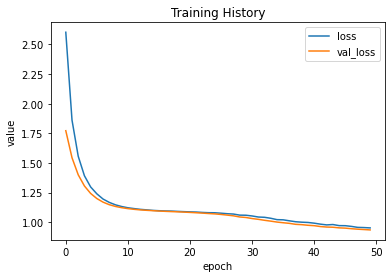

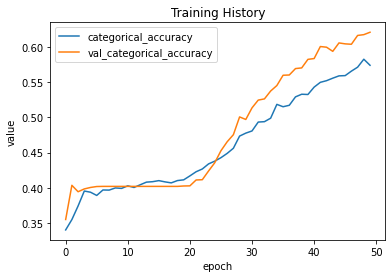

In [ ]:
# plotting the history of our models loss and accuracy to visualize its performance
def plot_train_history(hisData,t1,t2): 
    plt.plot(hisData.history[t1])
    plt.plot(hisData.history[t2])
    plt.title('Training History')
    plt.ylabel('value')
    plt.xlabel('epoch')
    plt.legend([t1, t2], loc='bottom right')
    plt.show()

plot_train_history(history, 'loss', 'val_loss')
plot_train_history(history, 'categorical_accuracy', 'val_categorical_accuracy')